# FFT saved file test

(256, 32769)
[443220.5        104993.29752197 100454.32354006  98664.69776779
  96157.22221626  98059.16150645  98876.92985105  90944.03720608
  96035.14316634  95353.64329046  93449.77231031  96775.65222558
  91902.81464037  92970.33827831  94051.26794053  93949.760758
  95514.63789198  97150.15769047  95117.42268286  95205.9017902
  95075.02414339  94178.18189142  93321.0664302   94726.36654346
  95544.34915049  96013.2841738   98895.37500475 105077.59627589
  97288.35524337  94550.81683804  95914.98963879  95991.73096951
  93084.01524407  95644.80449715  94495.19998325  94289.05818075
  96274.93471059  95732.96451306  95284.33516556  93735.33465911
  93587.49833205  92958.98344597  95544.29982911  95072.14979118
  95718.32988273  94763.75128729  96008.43925804  94885.80229549
  93957.68574467  94111.25817999  94418.07011184  95744.5051334
  95020.18515162  97267.03037796  94684.10371008  95466.32143168
  96023.15184171  96139.48730885  94618.04871749  95434.53957529
  95027.54556192

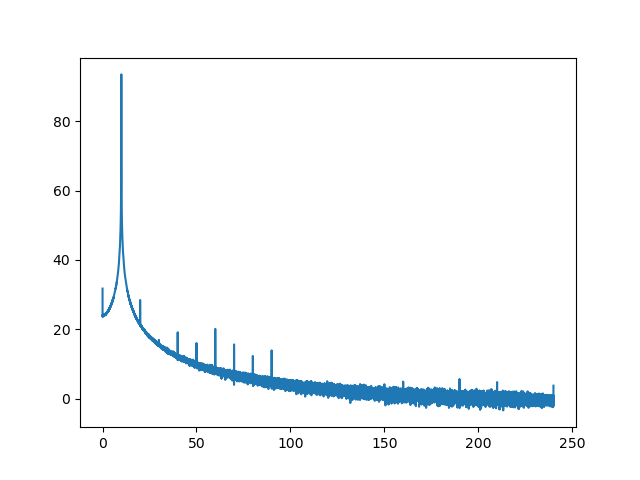

In [2]:
import numpy as np
import h5py as h5
from fft_helper import fft_to_dBm

%matplotlib widget

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

fname = './fft_test/2022-03-13/12/RAW_output1_0.h5'

f = h5.File(fname, 'r')

py = f['amplitude'][...]

print(py.shape)

st = 1/480.
px = rfftfreq(4096*16, d=st)

print(py[0,0:100])
plt.plot(px, fft_to_dBm(py[-1,...]))
plt.show()


# GPU FFT test

In [31]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

2022-03-05 16:19:11.111114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 47169 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:7c:00.0, compute capability: 7.5


['/device:GPU:0']

In [4]:
import torch

torchdevice = 0

names =[]

name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(torchdevice))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))

PyTorch
GPU available: True


In [16]:
import torch
import mkl_fft
def torch_ifft2_fft2(data):
    signal_ndim = 2
    data2 = torch.fft.fft(data)
    return torch.fft.ifft(data2)

def np_ifft2_fft2(data):
    data2 = mkl_fft.fft.fft2(data)
    return mkl_fft.fft.ifft2(data2)

sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors
names = []
totaltimes=[]
name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(0))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))
torchtimes = []
datas = [torch.randn(size=(x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

PyTorch
GPU available: True
Working on device: cuda:0
PyTorch GPU 512x512
26 µs ± 3.19 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
PyTorch GPU 1024x1024
172 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
PyTorch GPU 2048x2048
678 µs ± 31.3 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch GPU 4096x4096
2.7 ms ± 35.6 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
name = 'PyTorch\nCPU'
device_type = 'cpu'
device = torch.device(device_type)
names.append(name)
torchtimes = []
datas = [torch.randn((x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

Working on device: cpu
PyTorch CPU 512x512
296 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch CPU 1024x1024
533 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch CPU 2048x2048
18.1 ms ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
PyTorch CPU 4096x4096
61.4 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
import numpy as np

name = 'Numpy\nCPU'
names.append(name)
nptimes = []
datas = [np.random.normal(size=(x,x)).astype('complex128') for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o np_ifft2_fft2(data)
    nptimes.append(t)
totaltimes.append(nptimes)

Numpy CPU 512x512
9.3 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Numpy CPU 1024x1024
51 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 2048x2048
330 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 4096x4096
1.39 s ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
import cupy as cp

def cp_ifft2_fft2(data):
    data2 = cp.fft.fft2(data)
    return cp.fft.ifft2(data2)

name = 'CuPy\nGPU'
names.append(name)
cptimes = []
device = cp.cuda.Device(0)
with device:
    datas = [cp.random.normal(size=(x,x)).astype('complex128') for x in sizes]
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o cp_ifft2_fft2(data)
        cptimes.append(t)
    totaltimes.append(cptimes)

# # Clear cupy memory
# mempool = cp.get_default_memory_pool()
# del datas
# mempool.free_all_blocks()

CuPy GPU 512x512
216 µs ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 1024x1024
1.01 ms ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 2048x2048
3.89 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 4096x4096
15.8 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
